In [20]:
import numpy as np
import pandas as pd
from copy import deepcopy as dc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import lifelines.datasets
import torch
import torchtuples as tt
from pycox.models import CoxPH, CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv
from sklearn.model_selection import train_test_split
np.random.seed(1998)
_ = torch.manual_seed(1998)

In [21]:
df = pd.read_csv("data_ready_45.csv")

In [22]:
df_train, df_val_test = train_test_split(df, test_size=0.3, random_state=654)
df_val, df_test = train_test_split(df_val_test, test_size=0.5, random_state=654)

In [23]:
ssc = StandardScaler()
x_train = ssc.fit_transform(df_train.drop(columns=['time_frame', 'GRF_STAT_PA'])).astype('float32')
x_val = ssc.transform(df_val.drop(columns=['time_frame', 'GRF_STAT_PA'])).astype('float32')
x_test = ssc.transform(df_test.drop(columns=['time_frame', 'GRF_STAT_PA'])).astype('float32')

In [24]:
get_target = lambda df: (df['time_frame'].values, df['GRF_STAT_PA'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

In [25]:
in_features = x_train.shape[1]
num_nodes = [512, 256, 128]
out_features = 1
batch_norm = True
dropout = 0.3
output_bias = False
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

c:\Users\Omar\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchtuples\base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch

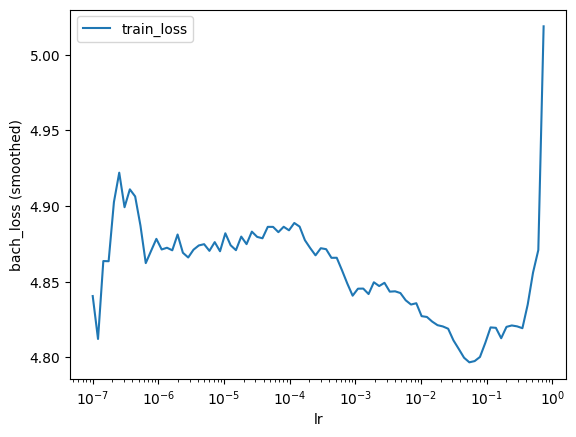

In [26]:
model = CoxPH(net, tt.optim.Adam)
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [27]:
lrfinder.get_best_lr()

0.005462277217684369

In [28]:
model.optimizer.set_lr(0.005)

In [29]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[1s / 1s],		train_loss: 4.8163,	val_loss: 4.5717
1:	[1s / 2s],		train_loss: 4.7082,	val_loss: 4.5396
2:	[0s / 3s],		train_loss: 4.6770,	val_loss: 4.5245
3:	[0s / 4s],		train_loss: 4.6498,	val_loss: 4.5156
4:	[0s / 5s],		train_loss: 4.6502,	val_loss: 4.5093
5:	[1s / 6s],		train_loss: 4.6194,	val_loss: 4.5040
6:	[1s / 7s],		train_loss: 4.6070,	val_loss: 4.5005
7:	[0s / 8s],		train_loss: 4.6011,	val_loss: 4.4960
8:	[0s / 9s],		train_loss: 4.5949,	val_loss: 4.4934
9:	[0s / 10s],		train_loss: 4.5806,	val_loss: 4.4912
10:	[0s / 10s],		train_loss: 4.5677,	val_loss: 4.4885
11:	[0s / 11s],		train_loss: 4.5727,	val_loss: 4.4881
12:	[0s / 12s],		train_loss: 4.5617,	val_loss: 4.4861
13:	[0s / 13s],		train_loss: 4.5637,	val_loss: 4.4852
14:	[1s / 14s],		train_loss: 4.5517,	val_loss: 4.4834
15:	[0s / 15s],		train_loss: 4.5486,	val_loss: 4.4830
16:	[0s / 16s],		train_loss: 4.5427,	val_loss: 4.4811
17:	[0s / 17s],		train_loss: 4.5503,	val_loss: 4.4804
18:	[0s / 18s],		train_loss: 4.5384,	val_loss: 

c:\Users\Omar\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchtuples\base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch

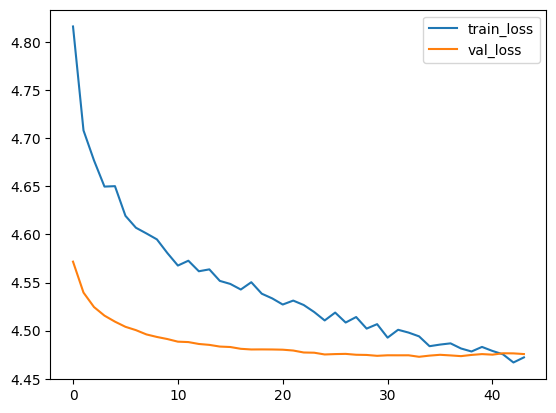

In [30]:
_ = log.plot()

In [31]:
model.partial_log_likelihood(*val).mean()

-7.4807987

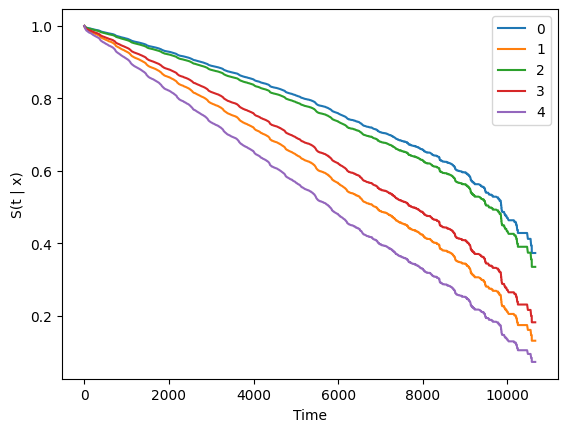

In [32]:
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [33]:
df.loc[df_test.index[:5]]

,GENDER,PERIP_VASC,AGE_DIAB,CREAT_TRR,AMIS,BMIS,DRMIS,HLAMIS,NPKID,NPPAN,...,MED_COND_TRR_is3,MALIG,HGT_CM_CALC,WGT_KG_CALC,BMI_CALC,PROTEIN_URINE,CARDARREST_NEURO,RESUSCIT_DUR,INOTROP_SUPPORT_DON,time_frame
11491,0.0,1.0,21.0,3.50,1.0,1.0,1.0,3.0,0.0,0.0,...,1.0,0.0,182.0,83.8,25.3,0.0,0.0,0.0,0.0,8193.0
14807,1.0,0.0,8.0,4.00,1.0,2.0,1.0,4.0,0.0,0.0,...,1.0,0.0,155.0,53.0,22.1,0.0,0.0,0.0,1.0,1519.0
12085,0.0,0.0,22.0,5.22,1.0,2.0,1.0,4.0,0.0,0.0,...,1.0,0.0,170.0,63.5,22.0,0.0,0.0,0.0,0.0,3048.0
24113,1.0,0.0,10.0,3.16,2.0,1.0,1.0,4.0,0.0,0.0,...,1.0,0.0,172.7,75.3,25.2,0.0,1.0,20.0,0.0,3691.0
13828,1.0,0.0,12.0,11.50,2.0,2.0,2.0,6.0,0.0,0.0,...,1.0,0.0,168.0,65.0,23.0,0.0,0.0,0.0,0.0,2640.0


In [34]:
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)

In [35]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [36]:
ev.concordance_td()

0.6617787591200834

In [37]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)

In [38]:
ev.integrated_brier_score(time_grid=time_grid)

0.17690064266499775